In [ ]:
import os
import pandas as pd
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\Sample_dataset.csv")

# Read TIF files and extract features using VGG16 model
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Load VGG16 model, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False)

image_features = []

for file in data["imageFilename"]:
    if pd.notna(file):
        file_str = str(file)  # Convert file to string
        image_path = os.path.join(image_directory, file_str)
        img = image.load_img(image_path, target_size=(224, 224))  # VGG16 expects images of size 224x224
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = base_model.predict(x)
        features = features.flatten()  # Flatten the extracted features
        image_features.append(features)

# Convert list of features to numpy array
image_features = np.array(image_features)

# Normalize the numerical data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()
numeric_data = scaler.fit_transform(numeric_data)

# Concatenate flattened image features and numeric data
X = np.concatenate((image_features, numeric_data), axis=1)

# Assume 'speed' and 'direction' are in data and we want to predict them
y = data[["speed", "direction"]].values

# Normalize speed       
speed = y[:, 0].reshape(-1, 1)
speed_scaler = MinMaxScaler()
speed_scaled = speed_scaler.fit_transform(speed).reshape(-1,)
y[:, 0] = speed_scaled

# Split into train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='linear')) 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


In [25]:
import pandas as pd 
import numpy as np
import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\Sample_dataset.csv")

# Read TIF files and extract features using VGG16 model
image_directory = r'D:\fourth year\gp\scratch\image_data'

image_data = []

for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())

# Normalize the image data        
image_data = np.array(image_data)        
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize the numerical data        
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()       
numeric_data = scaler.fit_transform(numeric_data)

# Reshape the image data  
image_data = np.reshape(image_data, (image_data.shape[0], -1))

# Concatenate the preprocessed image and numeric data
X = np.concatenate((image_data, numeric_data), axis=1)      

# Extract wind speed and direction from the dataframe    
y = data[["speed", "direction"]].values

# Split data into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=keras.regularizers.l2(0.001)))  
model.add(Dropout(0.25)) 

model.add(Dense(128, activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(2, activation='linear'))

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:

# Train the model      
history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test,y_test), verbose=1,  callbacks=[early_stop])

# Evaluate the model on the test set    
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)

Epoch 1/150
2/2 [==============================] - 1s 454ms/step - loss: 17.2571 - val_loss: 15.9335
Epoch 2/150
2/2 [==============================] - 1s 319ms/step - loss: 15.5987 - val_loss: 13.9877
Epoch 3/150
2/2 [==============================] - 1s 299ms/step - loss: 13.5482 - val_loss: 12.0569
Epoch 4/150
2/2 [==============================] - 1s 305ms/step - loss: 11.4535 - val_loss: 10.3321
Epoch 5/150
2/2 [==============================] - 1s 291ms/step - loss: 9.6547 - val_loss: 8.9359
Epoch 6/150
2/2 [==============================] - 1s 344ms/step - loss: 8.2420 - val_loss: 8.0770
Epoch 7/150
2/2 [==============================] - 1s 291ms/step - loss: 7.5596 - val_loss: 7.6196
Epoch 8/150
2/2 [==============================] - 1s 304ms/step - loss: 7.5511 - val_loss: 7.5521
Epoch 9/150
2/2 [==============================] - 1s 294ms/step - loss: 7.8308 - val_loss: 7.5965
Epoch 10/150
2/2 [==============================] - 1s 288ms/step - loss: 8.2221 - val_loss: 7.6336
E

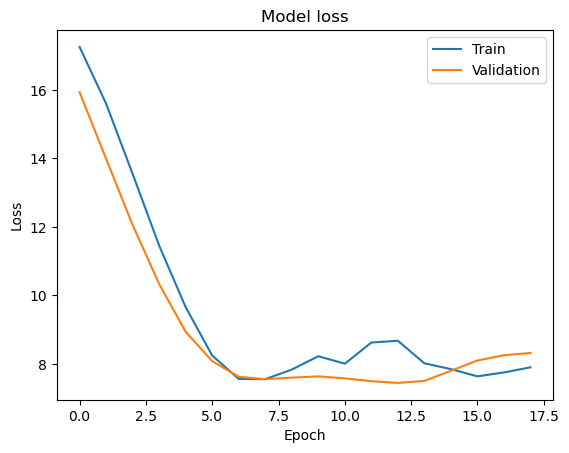

In [27]:
import matplotlib.pyplot as plt
# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict wind speed and heading values for the test set
y_pred = model.predict(X_test)

# Compute the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the mean squared error and mean absolute error
print('Mean squared error:', mse)
print('Mean absolute error:', mae)

1/1 [==============================] - 0s 82ms/step
Mean squared error: 66.41912640288423
Mean absolute error: 6.715763097286224


In [30]:
# Predict the wind speed and heading
y_pred = model.predict(X_test)

# Extract the predicted speed and heading
predicted_speed = y_pred[:, 0]
predicted_heading = y_pred[:, 1]

# Ensure the predicted heading is within the range 0-360
predicted_heading = (predicted_heading + 360) % 360

# Concatenate actual and predicted values and print them side by side
results = np.concatenate((y_test, y_pred), axis=1)
print("Actual Speed\tPredicted Speed\tActual direction\tPredicted direction")
for row in results:
    print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(row[0], row[2], row[1], row[3]))

1/1 [==============================] - 0s 42ms/step
Actual Speed	Predicted Speed	Actual direction	Predicted direction
8.70		11.16		-19.93		-13.45
18.60		9.91		-18.97		-12.04
11.40		14.85		-16.32		-17.95
10.80		9.55		-17.64		-11.57
14.50		8.48		-15.38		-10.36
13.60		8.53		-13.07		-10.29
15.30		9.23		-17.21		-11.18
15.80		14.52		-23.96		-17.57
9.00		4.45		-19.72		-5.42
18.40		9.01		-24.66		-10.98
9.20		27.22		-11.20		-32.71
11.50		6.48		-20.93		-7.81
10.50		8.99		-18.57		-10.92
8.10		5.29		-14.65		-6.35
18.70		13.78		-21.14		-16.54
16.70		5.92		-14.63		-7.20
18.50		12.94		-9.33		-15.75
14.80		13.62		-16.96		-16.58
14.30		7.33		-16.85		-8.79
10.20		6.94		-21.89		-8.33


# increase the dataset

In [32]:
import pandas as pd
import numpy as np
import rasterio
import seaborn as sns
import os
import shutil
import csv
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout


In [33]:
# Define the paths and file names
csv_file_path = r"D:\fourth year\gp\scratch\second_test500.csv"
input_image_folder = r'D:\\fourth year\\gp\\Copy of WFE\\all images'
output_image_folder =r"D:\fourth year\gp\scratch\image_data"

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Get the list of image names from the CSV file
image_names = data["imageFilename"].tolist()

# Loop through the input folder and copy the matching images to the output folder
for filename in os.listdir(input_image_folder):
    if filename in image_names:
        # If the image name matches, copy the image to the output folder
        shutil.copy(os.path.join(input_image_folder, filename), output_image_folder)
        print(f"Copied file {filename} to {output_image_folder}")


Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1000.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1002.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1003.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1006.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1008.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1141.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1142.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1144.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images.1145.tif to D:\fourth year\gp\scratch\image_data
Copied file wind_field_estimation_Orb_tnr_spk_TC_images

In [34]:
import pandas as pd 
import numpy as np
import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features using VGG16 model
image_directory = r'D:\fourth year\gp\scratch\image_data'

image_data = []

for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())

# Normalize the image data        
image_data = np.array(image_data)        
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize the numerical data        
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()       
numeric_data = scaler.fit_transform(numeric_data)

# Reshape the image data  
image_data = np.reshape(image_data, (image_data.shape[0], -1))

# Concatenate the preprocessed image and numeric data
X = np.concatenate((image_data, numeric_data), axis=1)      

# Extract wind speed and direction from the dataframe    
y = data[["speed", "direction"]].values

# Split data into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=keras.regularizers.l2(0.001)))  
model.add(Dropout(0.25)) 

model.add(Dense(128, activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(2, activation='linear'))

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [50]:
import pandas as pd 
import numpy as np
import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features  
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data            
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())         
image_data = np.array(image_data)        
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data        
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values      
scaler = MinMaxScaler()       
numeric_data = scaler.fit_transform(numeric_data)    

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)
y = data[["speed", "direction"]].values

# Split data           
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()
model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=keras.regularizers.l2(0.001)))  
model.add(Dropout(0.25)) 

model.add(Dense(128, activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))

model.add(Dense(2, activation='linear'))


# Compile model
optimizer = keras.optimizers.Adam(lr=1e-6)
model.compile(loss='mean_absolute_error', optimizer=optimizer)    
early_stop = EarlyStopping(patience=3)  

# Fit model  
history = model.fit(X_train, y_train, epochs=150, callbacks=[early_stop])

C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Epoch 1/150


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


13/13 [==============================] - 5s 335ms/step - loss: nan
Epoch 2/150
13/13 [==============================] - 4s 275ms/step - loss: nan
Epoch 3/150
13/13 [==============================] - 4s 278ms/step - loss: nan
Epoch 4/150
13/13 [==============================] - 3s 259ms/step - loss: nan
Epoch 5/150
13/13 [==============================] - 3s 241ms/step - loss: nan
Epoch 6/150
13/13 [==============================] - 3s 241ms/step - loss: nan
Epoch 7/150
13/13 [==============================] - 3s 241ms/step - loss: nan
Epoch 8/150
13/13 [==============================] - 3s 240ms/step - loss: nan
Epoch 9/150
13/13 [==============================] - 3s 238ms/step - loss: nan
Epoch 10/150
13/13 [==============================] - 3s 238ms/step - loss: nan
Epoch 11/150
13/13 [==============================] - 3s 242ms/step - loss: nan
Epoch 12/150
13/13 [==============================] - 3s 239ms/step - loss: nan
Epoch 13/150
13/13 [==============================] - 3s 237m

KeyboardInterrupt: 

In [52]:
import pandas as pd 
import numpy as np
import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features  
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data            
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())         
image_data = np.array(image_data)        
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data        
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values      
scaler = MinMaxScaler()       
numeric_data = scaler.fit_transform(numeric_data)    

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Split data           
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture           
model = Sequential()    
model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.0005)))    
model.add(Dropout(0.25)) 
...             
model.add(Dense(2, activation='linear'))

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_absolute_error', optimizer=optimizer)    
early_stop = EarlyStopping(monitor='val_loss', patience=3)  

# Fit model  
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, callbacks=[early_stop])


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Epoch 1/150


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 2s 163ms/step - loss: 0.8419 - val_loss: 0.7822
Epoch 2/150
10/10 [==============================] - 2s 152ms/step - loss: 0.7596 - val_loss: 0.7051
Epoch 3/150
10/10 [==============================] - 1s 140ms/step - loss: 0.6882 - val_loss: 0.6403
Epoch 4/150
10/10 [==============================] - 1s 138ms/step - loss: 0.6288 - val_loss: 0.5850
Epoch 5/150
10/10 [==============================] - 1s 145ms/step - loss: 0.5771 - val_loss: 0.5370
Epoch 6/150
10/10 [==============================] - 1s 148ms/step - loss: 0.5314 - val_loss: 0.4941
Epoch 7/150
10/10 [==============================] - 2s 155ms/step - loss: 0.4901 - val_loss: 0.4546
Epoch 8/150
10/10 [==============================] - 1s 136ms/step - loss: 0.4518 - val_loss: 0.4173
Epoch 9/150
10/10 [==============================] - 2s 154ms/step - loss: 0.4143 - val_loss: 0.3809
Epoch 10/150
10/10 [==============================] - 2s 159ms/step - loss: 0.3762 - val_loss: 0.3443
E

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict wind speed and heading values for the test set
y_pred = model.predict(X_test)

# Compute the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the mean squared error and mean absolute error
print('Mean squared error:', mse)
print('Mean absolute error:', mae)

4/4 [==============================] - 0s 19ms/step
Mean squared error: 0.026266069003566667
Mean absolute error: 0.10436405436389389


In [54]:
# Predict the wind speed and heading
y_pred = model.predict(X_test)

# Extract the predicted speed and heading
predicted_speed = y_pred[:, 0]
predicted_heading = y_pred[:, 1]

# Ensure the predicted heading is within the range 0-360
predicted_heading = (predicted_heading + 360) % 360

# Concatenate actual and predicted values and print them side by side
results = np.concatenate((y_test, y_pred), axis=1)
print("Actual Speed\tPredicted Speed\tActual direction\tPredicted direction")
for row in results:
    print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(row[0], row[2], row[1], row[3]))

4/4 [==============================] - 0s 21ms/step
Actual Speed	Predicted Speed	Actual direction	Predicted direction
0.59		0.65		0.41		0.40
0.74		0.70		0.56		0.54
0.83		0.68		0.53		0.53
1.00		0.72		0.60		0.59
0.38		0.62		0.14		0.18
0.67		0.64		0.35		0.36
0.66		0.70		0.55		0.54
0.66		0.69		0.43		0.42
0.96		0.73		0.80		0.78
1.00		0.71		0.64		0.62
0.76		0.74		0.57		0.55
0.80		0.67		0.50		0.49
0.63		0.65		0.29		0.29
0.29		0.63		0.31		0.33
0.46		0.66		0.44		0.43
0.35		0.67		0.55		0.55
0.51		0.65		0.60		0.60
0.39		0.72		0.68		0.67
0.00		0.34		1.00		0.89
0.44		0.69		0.53		0.52
0.25		0.65		0.48		0.47
0.42		0.75		0.39		0.39
0.67		0.77		0.54		0.53
0.47		0.70		0.78		0.76
0.67		0.69		0.60		0.60
0.71		0.72		0.68		0.66
1.00		0.67		0.56		0.54
0.68		0.69		0.46		0.46
1.00		0.71		0.52		0.51
0.70		0.69		0.63		0.62
0.52		0.73		0.67		0.65
0.74		0.77		0.64		0.64
0.66		0.68		0.43		0.43
1.00		0.72		0.67		0.66
0.45		0.74		0.49		0.49
0.57		0.69		0.57		0.56
0.31		0.67		0.51		0.50
0.56		0.66		0.38		0.37
0.86		0.

In [55]:
# Let's say y_pred are your model's predictions
y_pred = model.predict(X_test)

# Rescale back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Separate speed and direction for predicted and actual values
actual_speed = y_test_rescaled[:, 0]
predicted_speed = y_pred_rescaled[:, 0]
actual_direction = y_test_rescaled[:, 1]
predicted_direction = y_pred_rescaled[:, 1]

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual Speed": actual_speed,
    "Predicted Speed": predicted_speed,
    "Actual Direction": actual_direction,
    "Predicted Direction": predicted_direction
})

# Print the first 20 records
print(comparison_df.head(20))


4/4 [==============================] - 0s 21ms/step
    Actual Speed  Predicted Speed  Actual Direction  Predicted Direction
0           11.9        13.124260           -22.749           -22.978128
1           14.8        14.080119           -16.965           -17.413086
2           16.6        13.555924           -17.812           -18.157059
3           20.0        14.457501           -15.261           -15.698059
4            7.6        12.367239           -33.046           -31.556438
5           13.5        12.826385           -24.710           -24.639000
6           13.2        13.968454           -17.176           -17.755716
7           13.3        13.735529           -21.765           -22.178154
8           19.2        14.678542            -7.637            -8.410499
9           20.0        14.311384           -13.839           -14.378877
10          15.2        14.921782           -16.271           -17.066433
11          16.0        13.490692           -19.075           -19.430164

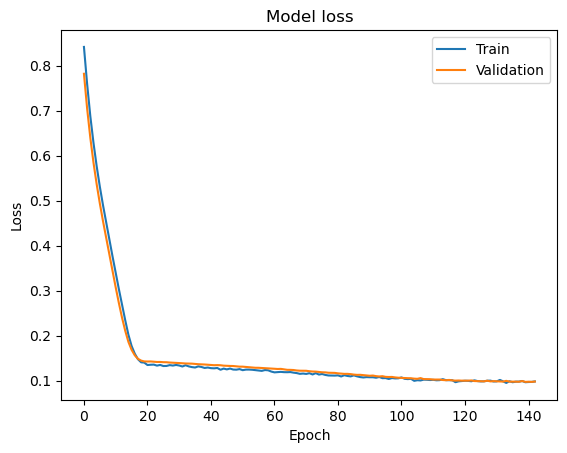

In [56]:
import matplotlib.pyplot as plt
# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [61]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = MinMaxScaler()
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = y[:, 1]  # Direction does not need to be normalized

# Split data
X_train, X_test, y_train_speed, y_test_speed, y_train_direction, y_test_direction = train_test_split(
    X, y_speed, y_direction, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.0005)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_squared_error', optimizer=optimizer)  # Use mean_squared_error for speed prediction
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.2, epochs=150, callbacks=[early_stop])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, scaler_y_speed.transform(y_test_speed))  # Scale test data for evaluation

print("Train loss (MSE):", train_loss)
print("Test loss (MSE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))
y_pred_direction = model.predict(X_test)

# Perform inverse scaling on predictions
y_pred = np.concatenate((y_pred_speed, y_pred_direction), axis=1)
y_pred = np.concatenate((scaler_y_speed.inverse_transform(y_pred_speed), y_pred_direction), axis=1)

# Evaluate predictions
speed_prediction_error = np.abs(y_pred_speed - scaler_y_speed.transform(y_test_speed))
direction_prediction_error = np.abs(y_pred_direction - y_test_direction)

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))
print("Mean Absolute Error (Direction):", np.mean(direction_prediction_error))


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Epoch 1/150


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 3s 221ms/step - loss: 0.7507 - val_loss: 0.6575
Epoch 2/150
10/10 [==============================] - 1s 150ms/step - loss: 0.6479 - val_loss: 0.5573
Epoch 3/150
10/10 [==============================] - 2s 157ms/step - loss: 0.5494 - val_loss: 0.4581
Epoch 4/150
10/10 [==============================] - 2s 159ms/step - loss: 0.4491 - val_loss: 0.3614
Epoch 5/150
10/10 [==============================] - 1s 146ms/step - loss: 0.3514 - val_loss: 0.2691
Epoch 6/150
10/10 [==============================] - 2s 156ms/step - loss: 0.2603 - val_loss: 0.1856
Epoch 7/150
10/10 [==============================] - 2s 170ms/step - loss: 0.1730 - val_loss: 0.1181
Epoch 8/150
10/10 [==============================] - 2s 162ms/step - loss: 0.1166 - val_loss: 0.0749
Epoch 9/150
10/10 [==============================] - 2s 165ms/step - loss: 0.0779 - val_loss: 0.0581
Epoch 10/150
10/10 [==============================] - 2s 177ms/step - loss: 0.0600 - val_loss: 0.0562
E

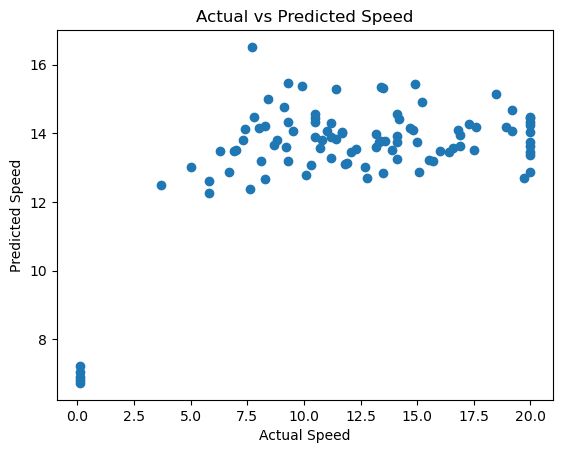

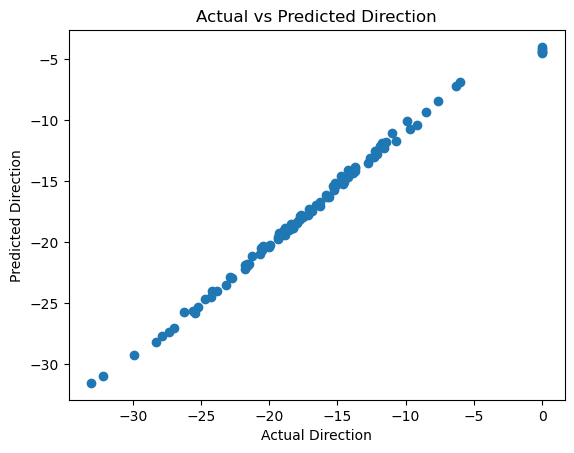

In [62]:
# Plot scatter plot for speed
plt.scatter(actual_speed, predicted_speed)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.show()

# Plot scatter plot for direction
plt.scatter(actual_direction, predicted_direction)
plt.title('Actual vs Predicted Direction')
plt.xlabel('Actual Direction')
plt.ylabel('Predicted Direction')
plt.show()

In [71]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = MinMaxScaler(feature_range=(0, 1))
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = (y[:, 1] + 360) % 360  # Shift and normalize wind direction values

# Split data
X_train, X_test, y_train_speed, y_test_speed, y_train_direction, y_test_direction = train_test_split(
    X, y_speed, y_direction, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.0005)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_squared_error', optimizer=optimizer)  # Use mean_squared_error for speed prediction
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.2, epochs=150, callbacks=[early_stop])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, y_test_speed)

print("Train loss (MSE):", train_loss)
print("Test loss (MSE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))
y_pred_direction = model.predict(X_test)
y_pred_direction = (y_pred_direction - 360) % 360  # Shift wind direction predictions back to the original range

# Perform inverse scaling on predictions
y_pred = np.concatenate((y_pred_speed, y_pred_direction), axis=1)

# Evaluate predictions
speed_prediction_error = np.abs(y_pred_speed - scaler_y_speed.inverse_transform(y_test_speed))
direction_prediction_error = np.abs(y_pred_direction - y_test_direction)

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))
print("Mean Absolute Error (Direction):", np.mean(direction_prediction_error))


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Epoch 1/150


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 2s 161ms/step - loss: 0.7445 - val_loss: 0.6509
Epoch 2/150
10/10 [==============================] - 1s 148ms/step - loss: 0.6420 - val_loss: 0.5496
Epoch 3/150
10/10 [==============================] - 1s 143ms/step - loss: 0.5392 - val_loss: 0.4500
Epoch 4/150
10/10 [==============================] - 1s 140ms/step - loss: 0.4407 - val_loss: 0.3518
Epoch 5/150
10/10 [==============================] - 1s 137ms/step - loss: 0.3389 - val_loss: 0.2574
Epoch 6/150
10/10 [==============================] - 1s 137ms/step - loss: 0.2487 - val_loss: 0.1733
Epoch 7/150
10/10 [==============================] - 1s 136ms/step - loss: 0.1631 - val_loss: 0.1079
Epoch 8/150
10/10 [==============================] - 1s 137ms/step - loss: 0.1093 - val_loss: 0.0694
Epoch 9/150
10/10 [==============================] - 1s 136ms/step - loss: 0.0743 - val_loss: 0.0582
Epoch 10/150
10/10 [==============================] - 1s 136ms/step - loss: 0.0667 - val_loss: 0.0580
E

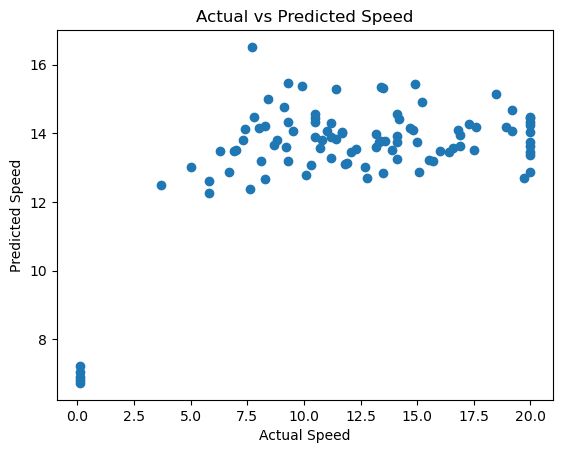

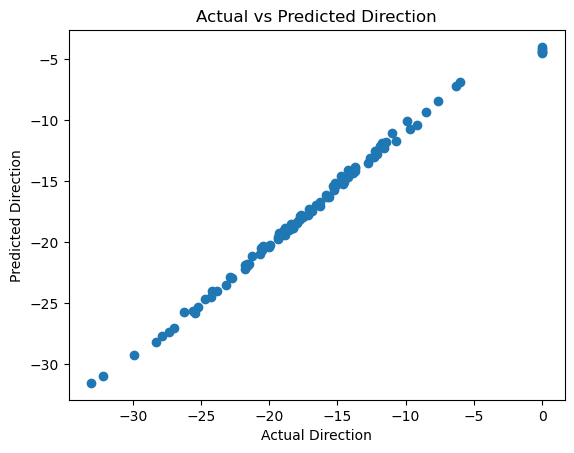

In [72]:
# Plot scatter plot for speed
plt.scatter(actual_speed, predicted_speed)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.show()

# Plot scatter plot for direction
plt.scatter(actual_direction, predicted_direction)
plt.title('Actual vs Predicted Direction')
plt.xlabel('Actual Direction')
plt.ylabel('Predicted Direction')
plt.show()

In [ ]:
# Assuming new_data is a DataFrame containing your new numeric data
# and new_image is a numpy array of your new image

# Prepare the numeric data
numeric_data = new_data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
numeric_data = scaler.transform(numeric_data)  # Use the same scaler you used for training

# Prepare the image data
new_image = (new_image - np.min(new_image)) / (np.max(new_image) - np.min(new_image))  # Normalize
new_image = np.reshape(new_image, (1, -1))  # Reshape

# Concatenate the image data and numeric data
X_new = np.concatenate((new_image, numeric_data), axis=1)
X_new = scaler.transform(X_new)  # Use the same scaler you used for training

# Ensure there are no NaN or Inf values
X_new = np.nan_to_num(X_new, copy=False)

# Now you can use the model to predict
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_new))
y_pred_direction = model.predict(X_new)
y_pred_direction = (y_pred_direction - 360) % 360  # Shift wind direction predictions back to the original range

# The predicted speed and direction
print("Predicted speed:", y_pred_speed)
print("Predicted direction:", y_pred_direction)


In [73]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        # Read and normalize each image
        image = src.read().squeeze()
        image = (image - image.min()) / (image.max() - image.min())
        image_data.append(image)

# Convert list of arrays to a 2D array
image_data = np.array([i.flatten() for i in image_data])

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = MinMaxScaler()
numeric_data = scaler.fit_transform(numeric_data)

# Concatenate image and numeric data
X = np.concatenate((image_data, numeric_data), axis=1)

# Normalize X values
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = MinMaxScaler(feature_range=(0, 1))
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = (y[:, 1] + 360) % 360  # Shift and normalize wind direction values

# Split data
X_train, X_test, y_train_speed, y_test_speed, y_train_direction, y_test_direction = train_test_split(
    X, y_speed, y_direction, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.0005)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_squared_error', optimizer=optimizer)  # Use mean_squared_error for speed prediction
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.2, epochs=150, callbacks=[early_stop])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, y_test_speed)

print("Train loss (MSE):", train_loss)
print("Test loss (MSE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))
y_pred_direction = model.predict(X_test)
y_pred_direction = (y_pred_direction - 360) % 360  # Shift wind direction predictions back to the original range

# Evaluate predictions
speed_prediction_error = np.abs(y_pred_speed - y_test_speed)
direction_prediction_error = np.abs(y_pred_direction - y_test_direction)

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))
print("Mean Absolute Error (Direction):", np.mean(direction_prediction_error))


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
10/10 [==============================] - 3s 177ms/step - loss: 1.2160 - val_loss: 0.3517
Epoch 2/150
10/10 [==============================] - 2s 159ms/step - loss: 0.8795 - val_loss: 0.4003
Epoch 3/150
10/10 [==============================] - 1s 150ms/step - loss: 0.7322 - val_loss: 0.3244
Epoch 4/150
10/10 [==============================] - 1s 143ms/step - loss: 0.5523 - val_loss: 0.3125
Epoch 5/150
10/10 [==============================] - 2s 153ms/step - loss: 0.4452 - val_loss: 0.3349
Epoch 6/150
10/10 [==============================] - 1s 136ms/step - loss: 0.4008 - val_loss: 0.2928
Epoch 7/150
10/10 [==============================] - 1s 139ms/step - loss: 0.4013 - val_loss: 0.2936
Epoch 8/150
10/10 [==============================] - 1s 144ms/step - loss: 0.3649 - val_loss: 0.3036
Epoch 9/150
10/10 [==============================] - 1s 141ms/step - loss: 0.3735 - val_loss: 0.2898
Epoch 10/150
10/10 [==============================] - 1s 144ms/step - loss: 0.3553 - val_lo

In [75]:
# Let's say y_pred are your model's predictions
y_pred = model.predict(X_test)

# Rescale back to original scale
y_pred_rescaled = scaler_y_speed.inverse_transform(y_pred)
y_test_rescaled_speed = scaler_y_speed.inverse_transform(y_test_speed)

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual Speed": y_test_rescaled_speed.flatten(),
    "Predicted Speed": y_pred_rescaled.flatten(),
})

# If you have the actual and predicted direction values, you can add them to the DataFrame:
comparison_df["Actual Direction"] = y_test_direction  # replace with actual direction values
comparison_df["Predicted Direction"] = y_pred_direction  # replace with predicted direction values

# Print the first 20 records
print(comparison_df.head(20))


4/4 [==============================] - 0s 16ms/step
    Actual Speed  Predicted Speed  Actual Direction  Predicted Direction
0           11.9        12.731191           337.251             0.634735
1           14.8        11.014580           343.035             0.548462
2           16.6         7.583725           342.188             0.376068
3           20.0        12.106973           344.739             0.603363
4            7.6        10.527328           326.954             0.523987
5           13.5        11.143772           335.290             0.554962
6           13.2        13.804889           342.824             0.688690
7           13.3        11.164787           338.235             0.556030
8           19.2         8.099171           352.363             0.401978
9           20.0        11.472610           346.161             0.571503
10          15.2        11.092116           343.729             0.552368
11          16.0        10.598907           340.925             0.527588

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = StandardScaler()
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = y[:, 1]  # Direction does not need to be normalized

# Split data
X_train, X_test, y_train_speed, y_test_speed = train_test_split(
    X, y_speed, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(512, activation='elu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss='mean_absolute_error', optimizer=optimizer)  # Use mean_absolute_error for speed prediction
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.2, epochs=150, callbacks=[early_stop])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, y_test_speed)  # No need to scale test data for evaluation

print("Train loss (MAE):", train_loss)
print("Test loss (MAE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))

# Evaluate predictions
speed_prediction_error = np.abs(scaler_y_speed.inverse_transform(y_pred_speed) - scaler_y_speed.inverse_transform(y_test_speed))

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
10/10 [==============================] - 4s 316ms/step - loss: 1.7660 - val_loss: 1.8306
Epoch 2/150
10/10 [==============================] - 3s 269ms/step - loss: 1.7382 - val_loss: 1.8014
Epoch 3/150
10/10 [==============================] - 3s 271ms/step - loss: 1.7101 - val_loss: 1.7724
Epoch 4/150
10/10 [==============================] - 3s 272ms/step - loss: 1.6741 - val_loss: 1.7441
Epoch 5/150
10/10 [==============================] - 3s 268ms/step - loss: 1.6502 - val_loss: 1.7162
Epoch 6/150
10/10 [==============================] - 3s 269ms/step - loss: 1.6235 - val_loss: 1.6892
Epoch 7/150
10/10 [==============================] - 3s 271ms/step - loss: 1.5922 - val_loss: 1.6627
Epoch 8/150
10/10 [==============================] - 3s 281ms/step - loss: 1.5697 - val_loss: 1.6370
Epoch 9/150
10/10 [==============================] - 3s 267ms/step - loss: 1.5402 - val_loss: 1.6120
Epoch 10/150
10/10 [==============================] - 3s 264ms/step - loss: 1.5159 - val_lo

In [2]:
# Generate predictions for all test data
y_pred_speed = model.predict(X_test)

# Inverse transform the predictions and the actual values to get them on the original scale
y_pred_speed_inv = scaler_y_speed.inverse_transform(y_pred_speed)
y_test_speed_inv = scaler_y_speed.inverse_transform(y_test_speed)

# Choose a random index from the test set
index = np.random.randint(0, len(X_test))

# Print the actual vs predicted values for this sample
print(f"Sample #{index}")
print(f"Actual Speed: {y_test_speed_inv[index]}")
print(f"Predicted Speed: {y_pred_speed_inv[index]}")

# Compute the error for this sample
error = abs(y_test_speed_inv[index] - y_pred_speed_inv[index])
print(f"Error: {error}")


4/4 [==============================] - 0s 32ms/step
Sample #58
Actual Speed: [16.4]
Predicted Speed: [13.541798]
Error: [2.85820236]


In [3]:
import random

# Generate predictions for all test data
y_pred_speed = model.predict(X_test)

# Inverse transform the predictions and the actual values to get them on the original scale
y_pred_speed_inv = scaler_y_speed.inverse_transform(y_pred_speed)
y_test_speed_inv = scaler_y_speed.inverse_transform(y_test_speed)

# Choose 20 random indices from the test set
indices = random.sample(range(len(X_test)), 20)

for index in indices:
    # Print the actual vs predicted values for each sample
    print(f"Sample #{index}")
    print(f"Actual Speed: {y_test_speed_inv[index]}")
    print(f"Predicted Speed: {y_pred_speed_inv[index]}")

    # Compute the error for each sample
    error = abs(y_test_speed_inv[index] - y_pred_speed_inv[index])
    print(f"Error: {error}")
    print("-----------------------------")


4/4 [==============================] - 0s 31ms/step
Sample #19
Actual Speed: [8.8]
Predicted Speed: [14.172133]
Error: [5.37213345]
-----------------------------
Sample #12
Actual Speed: [12.7]
Predicted Speed: [13.123994]
Error: [0.42399387]
-----------------------------
Sample #59
Actual Speed: [5.8]
Predicted Speed: [12.143877]
Error: [6.34387703]
-----------------------------
Sample #22
Actual Speed: [13.4]
Predicted Speed: [14.63029]
Error: [1.23029003]
-----------------------------
Sample #30
Actual Speed: [10.5]
Predicted Speed: [15.099571]
Error: [4.59957123]
-----------------------------
Sample #80
Actual Speed: [17.5]
Predicted Speed: [13.51036]
Error: [3.98964024]
-----------------------------
Sample #69
Actual Speed: [9.9]
Predicted Speed: [14.91487]
Error: [5.01487026]
-----------------------------
Sample #41
Actual Speed: [12.1]
Predicted Speed: [13.505445]
Error: [1.40544453]
-----------------------------
Sample #14
Actual Speed: [9.3]
Predicted Speed: [13.439262]
Error:

In [6]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os
import random

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Remove potential outliers in 'speed' using the IQR method
Q1 = data['speed'].quantile(0.25)
Q3 = data['speed'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['speed'] < (Q1 - 1.5 * IQR)) | (data['speed'] > (Q3 + 1.5 * IQR)))]

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Feature Engineering - Adding a new feature "dx/dy"
data["dx/dy"] = data["dx"]/data["dy"]

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio", "dx/dy"]].values
scaler = RobustScaler() # Using RobustScaler that's less prone to outliers
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = StandardScaler()
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = y[:, 1]  # Direction does not need to be normalized

# Split data
X_train, X_test, y_train_speed, y_test_speed = train_test_split(
    X, y_speed, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(512, activation='elu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_squared_error', optimizer=optimizer)  # Use mean_squared_error for speed prediction
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.3, epochs=150, callbacks=[early_stop])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, scaler_y_speed.transform(y_test_speed))  # Scale test data for evaluation

print("Train loss (MSE):", train_loss)
print("Test loss (MSE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))

# Perform inverse scaling on predictions
y_pred = y_pred_speed

# Evaluate predictions
speed_prediction_error = np.abs(y_pred_speed - scaler_y_speed.transform(y_test_speed))

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))

# Check the actual vs predicted values for 20 random samples from your test set
indices = random.sample(range(len(X_test)), 20)
y_pred_speed_inv = scaler_y_speed.inverse_transform(y_pred_speed)
y_test_speed_inv = scaler_y_speed.inverse_transform(y_test_speed)

for index in indices:
    # Print the actual vs predicted values for each sample
    print(f"Sample #{index}")
    print(f"Actual Speed: {y_test_speed_inv[index]}")
    print(f"Predicted Speed: {y_pred_speed_inv[index]}")

    # Compute the error for each sample
    error = abs(y_test_speed_inv[index] - y_pred_speed_inv[index])
    print(f"Error: {error}")
    print("-----------------------------")


Epoch 1/150
9/9 [==============================] - 6s 566ms/step - loss: 4512.4927 - val_loss: 308.5491
Epoch 2/150
9/9 [==============================] - 5s 578ms/step - loss: 8888.5371 - val_loss: 2079.3125
Epoch 3/150
9/9 [==============================] - 6s 646ms/step - loss: 6666.0142 - val_loss: 503.9735
Epoch 4/150
9/9 [==============================] - 5s 566ms/step - loss: 4579.7588 - val_loss: 17.9493
Epoch 5/150
9/9 [==============================] - 5s 556ms/step - loss: 2686.4128 - val_loss: 46.1489
Epoch 6/150
9/9 [==============================] - 6s 652ms/step - loss: 2560.8557 - val_loss: 15.2309
Epoch 7/150
9/9 [==============================] - 6s 642ms/step - loss: 2240.9556 - val_loss: 136.9933
Epoch 8/150
9/9 [==============================] - 6s 702ms/step - loss: 2674.8457 - val_loss: 148.2051
Epoch 9/150
9/9 [==============================] - 5s 591ms/step - loss: 1350.3232 - val_loss: 18.9352
Epoch 10/150
9/9 [==============================] - 5s 622ms/step -

In [7]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import rasterio
import os
import random

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y_speed = StandardScaler()
y_speed = scaler_y_speed.fit_transform(y[:, 0].reshape(-1, 1))
y_direction = y[:, 1]  # Direction does not need to be normalized

# Split data
X_train, X_test, y_train_speed, y_test_speed = train_test_split(
    X, y_speed, test_size=0.2, random_state=42)

# Model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Output layer for speed prediction

# Compile model
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)  # Use mean_squared_error for speed prediction

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Fit model
history = model.fit(X_train, y_train_speed, validation_split=0.2, epochs=150, callbacks=[early_stop, reduce_lr])

# Evaluate model
train_loss = model.evaluate(X_train, y_train_speed)
test_loss = model.evaluate(X_test, scaler_y_speed.transform(y_test_speed))  # Scale test data for evaluation

print("Train loss (MSE):", train_loss)
print("Test loss (MSE):", test_loss)

# Predictions
y_pred_speed = scaler_y_speed.inverse_transform(model.predict(X_test))

# Perform inverse scaling on predictions
y_pred = y_pred_speed

# Evaluate predictions
speed_prediction_error = np.abs(y_pred_speed - scaler_y_speed.transform(y_test_speed))

print("Mean Absolute Error (Speed):", np.mean(speed_prediction_error))

# Check the actual vs predicted values for 20 random samples from your test set
indices = random.sample(range(len(X_test)), 20)
y_pred_speed_inv = scaler_y_speed.inverse_transform(y_pred_speed)
y_test_speed_inv = scaler_y_speed.inverse_transform(y_test_speed)

for index in indices:
    # Print the actual vs predicted values for each sample
    print(f"Sample #{index}")
    print(f"Actual Speed: {y_test_speed_inv[index]}")
    print(f"Predicted Speed: {y_pred_speed_inv[index]}")
    
    # Compute the error for each sample
    error = abs(y_test_speed_inv[index] - y_pred_speed_inv[index])
    print(f"Error: {error}")
    print("-----------------------------")


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch 1/150
10/10 [==============================] - 2s 136ms/step - loss: 3.3935 - val_loss: 3.5290 - lr: 0.0100
Epoch 2/150
10/10 [==============================] - 1s 101ms/step - loss: 3.2871 - val_loss: 3.4316 - lr: 0.0100
Epoch 3/150
10/10 [==============================] - 1s 104ms/step - loss: 3.2118 - val_loss: 3.3550 - lr: 0.0100
Epoch 4/150
10/10 [==============================] - 1s 105ms/step - loss: 3.1201 - val_loss: 3.2958 - lr: 0.0100
Epoch 5/150
10/10 [==============================] - 1s 108ms/step - loss: 3.1666 - val_loss: 3.2438 - lr: 0.0100
Epoch 6/150
10/10 [==============================] - 1s 103ms/step - loss: 3.0283 - val_loss: 3.0833 - lr: 0.0100
Epoch 7/150
10/10 [==============================] - 1s 113ms/step - loss: 2.9059 - val_loss: 3.0135 - lr: 0.0100
Epoch 8/150
10/10 [==============================] - 1s 104ms/step - loss: 2.7730 - val_loss: 2.9631 - lr: 0.0100
Epoch 9/150
10/10 [==============================] - 1s 109ms/step - loss: 2.6839 - val_

In [9]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import rasterio
import os

# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features
image_directory = r'D:\fourth year\gp\scratch\image_data'

# Normalize image data
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())
image_data = np.array(image_data)
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_data)

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y_speed = data[["speed"]].values
y_direction = data[["direction"]].values

# Normalize y values
scaler_y_speed = StandardScaler()
y_speed = scaler_y_speed.fit_transform(y_speed)

# Split data
X_train, X_test, y_train_speed, y_test_speed, y_train_direction, y_test_direction = train_test_split(
    X, y_speed, y_direction, test_size=0.2, random_state=42)

# Shared layers
inputs = keras.Input(shape=(X.shape[1],))
x = Dense(512, activation='elu', kernel_initializer='he_uniform',
                kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
x = Dropout(0.5)(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.5)(x)
shared_model = Dense(128, activation='elu')(x)

# Speed head
speed_output = Dense(1, activation='linear', name='speed_output')(shared_model)

# Direction head
direction_output = Dense(1, activation='linear', name='direction_output')(shared_model)

# Combined model
model = keras.Model(inputs=inputs, outputs=[speed_output, direction_output])

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss={'speed_output': 'mean_absolute_error', 'direction_output': 'mean_absolute_error'}, 
              optimizer=optimizer, 
              metrics={'speed_output': 'mean_absolute_error', 'direction_output': 'mean_absolute_error'})

# Fit model
history = model.fit(X_train, [y_train_speed, y_train_direction], validation_split=0.2, epochs=150)

# Evaluate model
train_loss = model.evaluate(X_train, [y_train_speed, y_train_direction])
test_loss = model.evaluate(X_test, [y_test_speed, y_test_direction])

print("Train loss (MAE):", train_loss)
print("Test loss (MAE):", test_loss)


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch 1/150
10/10 [==============================] - 7s 555ms/step - loss: 18.0993 - speed_output_loss: 0.7474 - direction_output_loss: 17.0003 - speed_output_mean_absolute_error: 0.7474 - direction_output_mean_absolute_error: 17.0003 - val_loss: 16.1999 - val_speed_output_loss: 0.8324 - val_direction_output_loss: 15.3321 - val_speed_output_mean_absolute_error: 0.8324 - val_direction_output_mean_absolute_error: 15.3321
Epoch 2/150
10/10 [==============================] - 5s 516ms/step - loss: 12.9695 - speed_output_loss: 0.7512 - direction_output_loss: 12.1543 - speed_output_mean_absolute_error: 0.7512 - direction_output_mean_absolute_error: 12.1543 - val_loss: 6.4700 - val_speed_output_loss: 0.8238 - val_direction_output_loss: 5.5881 - val_speed_output_mean_absolute_error: 0.8238 - val_direction_output_mean_absolute_error: 5.5881
Epoch 3/150
10/10 [==============================] - 5s 510ms/step - loss: 5.4446 - speed_output_loss: 0.8310 - direction_output_loss: 4.5861 - speed_output_

In [13]:
# Make predictions on the first 20 samples of the test data
y_pred = model.predict(X_test[:20])

# Inverse transform the predictions (so they're in the original units)
y_pred_speed = scaler_y_speed.inverse_transform(y_pred[0])

# Inverse transform the actual speed values
y_test_speed_inverse = scaler_y_speed.inverse_transform(y_test_speed[:20])

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Actual Speed": y_test_speed_inverse.flatten(),
    "Predicted Speed": y_pred_speed.flatten()
})

print(comparison_df)


1/1 [==============================] - 0s 48ms/step
    Actual Speed  Predicted Speed
0           11.9        12.661314
1           14.8        14.424597
2           16.6        13.969633
3           20.0        15.045658
4            7.6        11.946678
5           13.5        12.595098
6           13.2        14.325017
7           13.3        13.288123
8           19.2        16.758030
9           20.0        15.216888
10          15.2        15.042094
11          16.0        13.241304
12          12.7        12.503047
13           5.8        12.251545
14           9.3        12.815459
15           7.0        14.300592
16          10.3        14.798875
17           7.8        16.704056
18           0.1         3.299130
19           8.8        14.167949
